In [ ]:
import sys
sys.path.append("../")

In [ ]:
header_length = len("2022-10-05 11:56:15.580  INFO 8982 --- [           main] ")
header_length

In [ ]:
event_length = len("f.i.sirene4.repertoire.BatchApplication  ")
event_length

In [ ]:
first_line = "2022-10-05 11:56:15.580  INFO 8982 --- [           main] f.i.sirene4.repertoire.BatchApplication  : Starting BatchApplication v2.3.3 using Java 11.0.16.1 on qfbatrelst01.ad.insee.intra with PID 8982 (/opt/insee/sirene4/qf3/lib/repertoire-batch-2.3.3.jar started by www-data in /opt/insee/sirene4/qf3/tmp)"

In [ ]:
line_without_timestamp = first_line[header_length:]
event_type = line_without_timestamp[:event_length]
event_type.rstrip()

In [ ]:
description = line_without_timestamp[event_length + 2:]
description

In [ ]:
import pandas as pd

def extract_log_info(f):
    event_types = []
    descriptions = []
    for line in f:
        line_without_timestamp = line[header_length:]
        if not line_without_timestamp:
            continue
        event_types.append(line_without_timestamp[:event_length].rstrip())
        descriptions.append(line_without_timestamp[event_length + 2:])
    return pd.DataFrame(list(zip(event_types, descriptions)), columns =['event_type', 'description'])

with open("../data/api_log.log") as f:
    df = extract_log_info(f)

In [ ]:
df

In [ ]:
identifier = "s.i.AbstractBatchCodificationServiceImpl"
log_info = "r.b.j.c.s.i.BatchCodificationServiceImpl"
raw_input = "stractLiasse1ToLiasseVarInteretProcessor"

In [ ]:
df_ids = df[df.event_type == identifier]
df_ids.head()

In [ ]:
df_info = df[df.event_type == log_info]
df_info.head()

In [ ]:
df_ids.shape

In [ ]:
df_info.shape

In [ ]:
df_raw_input = df[df.event_type == raw_input]
df_raw_input.head()

In [ ]:
df_raw_input = df_raw_input[df_raw_input.description.str.startswith("LiasseVarInteretCodification")]
df_raw_input.head()

In [ ]:
df_raw_input.shape

In [ ]:
test_str = df_raw_input.iloc[0, 1]
test_str

In [ ]:
import re

regex = re.compile(r'norme=([^,]*),')
matches = regex.search(test_str)
matches.group(1)

In [ ]:
regex = re.compile(r'liasseType=([^,]*),')
matches = regex.search(test_str)
matches.group(1)

In [ ]:
regex

In [ ]:
raw_fields = [
    "norme",
    "siren",
    "nic",
    "liasseType",
    "categorieJuridique",
    "domas",
    "ssdom",
    "domaineAssoc",
    "ssDomaineAssoc",
    "libelleActivitePrincipaleEtablissement",
    "sedentarite",
    "natureActivites",
    "surface",
    "lieuExercice",
    "presenceSalaries"
]
raw_regexes = [re.compile(r'{}'.format(field + '=([^,]*)[,\]]')) for field in raw_fields]
raw_regexes

In [ ]:
def parse_raw_input(raw_input, fields, regexes):
    raw_input_dict = {}
    for field, regex in zip(fields, regexes):
        matches = regex.search(raw_input)
        raw_input_dict[field] = matches.group(1)
    return raw_input_dict

In [ ]:
parse_raw_input(test_str, raw_fields, raw_regexes)

In [ ]:
dict_series = [parse_raw_input(raw_input, raw_fields, raw_regexes) for raw_input in df_raw_input.description]

In [ ]:
pd.DataFrame(list(dict_series))

In [ ]:
test_str = df_info.iloc[0, 1]
test_str

In [ ]:
info_fields = [
    "libelleActivite",
    "natureActivites",
    "liasseType",
    "evenementType",
    "surface",
    "libelleNettoye",
    "predictions",
    "bilan"
]
info_regexes = [re.compile(r'{}'.format(field + '=([^,]*),')) for field in info_fields]

info_fields.append("fasttextVersion")
info_regexes.append(re.compile(r'fasttextVersion=([^,]*)\]'))

info_regexes

In [ ]:
parse_raw_input(test_str, info_fields, info_regexes)

In [ ]:
def extract_first_pred(predictions):
    regex = re.compile(r'proposé = ([^;]*) ;.*associée = ([^;]*)\].*proposé = ([^;]*) ;.*associée = ([^;]*)\]')
    matches = regex.search(predictions)
    first_code = matches.group(1)
    second_code = matches.group(3)
    first_proba = matches.group(2)
    second_proba = matches.group(4)
    return (first_code, second_code, float(first_proba), float(second_proba))

extract_first_pred(parse_raw_input(test_str, info_fields, info_regexes)["predictions"])

In [ ]:
dict_series = [parse_raw_input(info_input, info_fields, info_regexes) for info_input in df_info.description]

In [ ]:
df = pd.DataFrame(list(dict_series))

In [ ]:
predictions = [extract_first_pred(predictions) for predictions in df["predictions"]]
df["first_pred"] = [prediction[0] for prediction in predictions]
df["second_pred"] = [prediction[0] for prediction in predictions]
df["first_proba"] = [prediction[0] for prediction in predictions]
df["second_proba"] = [prediction[0] for prediction in predictions]

df

In [ ]:
import pandas as pd

df = pd.read_csv("comparison.csv")

In [ ]:
df = df[~df.RAW.str.contains("oeuvre")]

In [ ]:
df.RAW.iloc[7]

In [ ]:
df.RAW.replace(
    to_replace=r"(\s|^)([a-z]{1})(?:\s|$)", value=r'\1', regex=True
).iloc[7]

In [ ]:
df.RAW.replace(
    to_replace=r"\b([a-z]{1})\b", value=' ', regex=True
).iloc[7]

In [6]:
import sys
import pandas as pd
import unidecode
import re
import string
import numpy as np
from nltk.corpus import stopwords as ntlk_stopwords
from nltk.stem.snowball import SnowballStemmer
from enum import Enum

sys.path.append("../")

HEADER_LEN = 58
EVENT_LEN = 41


class EventType(Enum):
    """

    """
    ID = "s.i.AbstractBatchCodificationServiceImpl"
    INFO = "r.b.j.c.s.i.BatchCodificationServiceImpl"
    RAW_INPUT = "stractLiasse1ToLiasseVarInteretProcessor"


def extract_log_info(f):
    """_summary_

    Args:
        f (_type_): _description_

    Returns:
        _type_: _description_
    """
    event_types = []
    descriptions = []
    for line in f:
        line_without_timestamp = line[HEADER_LEN:]
        if not line_without_timestamp:
            continue
        event_types.append(line_without_timestamp[:EVENT_LEN].rstrip())
        descriptions.append(line_without_timestamp[EVENT_LEN + 2:])
    return pd.DataFrame(
        list(zip(event_types, descriptions)),
        columns=['event_type', 'description']
    )


def parse_raw_input(raw_input, fields, regexes):
    """_summary_

    Args:
        raw_input (_type_): _description_
        fields (_type_): _description_
        regexes (_type_): _description_

    Returns:
        _type_: _description_
    """
    raw_input_dict = {}
    for field, regex in zip(fields, regexes):
        matches = regex.search(raw_input)
        if matches.group(1) is not None:
            raw_input_dict[field] = matches.group(1).strip('"')
        else:
            raw_input_dict[field] = matches.group(2)
    return raw_input_dict


def extract_first_pred(predictions):
    """_summary_

    Args:
        predictions (_type_): _description_

    Returns:
        _type_: _description_
    """
    regex = re.compile(r'proposé = ([^;]*) ;.*associée = ([^;]*)\].*proposé = ([^;]*) ;.*associée = ([^;]*)\]')
    matches = regex.search(predictions)
    first_code = matches.group(1)
    second_code = matches.group(3)
    first_proba = matches.group(2)
    second_proba = matches.group(4)
    return (first_code, second_code, float(first_proba), float(second_proba))


def clean_lib(df, text_feature):
        """
        Cleans a text feature for pd.DataFrame `df` at index idx.

        Args:
            df (pd.DataFrame): DataFrame.
            text_feature (str): Name of the text feature.

        Returns:
            df (pd.DataFrame): DataFrame.
        """
#        Libellé vide de sens fournit par Christine
#        LibVideSens = r"\bidem\b|\bvoir ci dessous\b|\[vide\]|\bundefined\b|\bpas d objet\b|\(voir ci dessus\)|\(voir extrait siege social\/etablissement principal\)|\bcf activite principale\b|\bcf activite principale et objet\b|\bcf activites de l entreprise\b|\bcf activites principales de l entreprise\b|\bcf actvites principales\b|\bcf k bis\b|\bcf le principales activites de l  entreprise\b|\bcf le sprincipale activites de l  entreprise\b|\bcf le sprincipales activites de l  entreprise\b|\bcf les activites principales de l  entreprise\b|\bcf les ppales activites de l  entreprise\b|\bcf les ppales activites de la ste\b|\bcf les principale activites de l  entreprise\b|\bcf les principales activites\b|\bcf les principales activites de l  entreprise\b|\bcf les principales activites de l  entreprises\b|\bcf les principales activites ppales de l  entreprise\b|\bcf les principales activtes de l  entreprise\b|\bcf les principales acttivites de l  entreprise\b|\bcf les prinipales activites de l  entreprise\b|\bcf lesprincipales activites de l  entreprise\b|\bcf objet\b|\bcf obs\b|\bcf principales activite de l  entreprise\b|\bcf principales activites de l  entreprise\b|cf rubrique \"principales activites de l entreprise\" idem|cf rubrique n2 ci dessus \(743b\)|\bcf supra\b|\bcf ci  dessus\b|\bcommerce de detail, idem case 2\b|\bextension a: voir ci dessus\b|\bid\b|\bid principales activites\b|\bid principales activites de l  entreprise\b|\bidem ci dessus\b|idem \( voir principales activites\)|\bidem  dessus\b|\bidem 1ere page\b|\bidem a principales activites de l  entreprise\b|\bidem activiet eprincipale\b|\bidem activite\b|\bidem activite 1ere page\b|\bidem activite ci  dessus\b|\bidem activite de l  entreprise\b|\bidem activite enoncee ci  dessus\b|\bidem activite entreprise\b|\bidem activite generales\b|\bidem activite premiere page\b|\bidem activite principale\b|\bidem activite princippale\b|\bidem activite prinicpale\b|\bidem activite sur 1ere page\b|\bidem activites ci dessus\b|\bidem activites declarees au siege et principal\b|\bidem activites enoncees ci dessus\b|\bidem activites entreprise\b|\bidem activites principales\b|\bidem activites principales de l entreprise\b|\bidem activites siege\b|\bidem activte principale\b|\bidem activtie 1ere page\b|\bidem au siege\b|\bidem au siege social\b|\bidem aux principales actiivtes\b|\bidem aux principales activites\b|\bidem case 13\b|\bidem ci dessous\b|\bidem ci dessus enoncee\b|\bidem cidessus\b|\bidem objet\b|\bidem premiere page\b|\bidem pricincipales activites de l entreprise\b|\bidem pricipales activites\b|\bidem principale activite\b|\bidem principales activite de l entreprise\b|\bidem principales activite de l entreprises\b|\bidem principales activite l entreprise\b|\bidem principales activites\b|\bidem principales activites citees ci dessus\b|\bidem principales activites de l entreprises\b|idem principales activites de l entreprise\(objet\)|\bidem principales activites et objet social\b|\bidem principales activitse de l entreprise\b|\bidem que celle decrite plus haut\b|\bidem que ci dessus\b|\bidem que l activite decrite plus haut\b|\bidem que les activites principales\b|\bidem que les activites principales ci dessus\b|\bidem que les activitges principales\b|\bidem que les principales activites\b|\bidem que les principales activites de l entreprise\b|\bidem que pour le siege\b|\bidem rubrique principales activites de l entreprise\b|\bidem siege\b|idem siege \+ voir observation|\bidem siege et ets principal\b|\bidem siege social\b|idem siege, \(\+ articles americains\)|\bidem societe\b|\bidem voir activite principale\b|\bidem voir ci dessus\b|\bidentique a l objet social indique en case 2 de l imprime m2\b|\bidm ci dessus\b|\bnon indiquee\b|\bnon precise\b|\bnon precisee\b|\bnon precisees\b|\bvoir 1ere page\b|\bvoir activite ci dessus\b|\bvoir activite principale\b|\bvoir activite principale ci dessus\b|\bvoir activites principales\b|\bvoir cidessus\b|\bvoir idem ci dessus\b|\bvoir objet social\b|\bvoir page 1\b|\bvoir page precedente\b|\bvoir plus haut\b|\bvoir princiale activite\b|\bvoir princiales activites\b|\bvoir princiapales activites\b|\bvoir princiaples activites\b|\bvoir principale activite\b|\bvoir principales activites\b|\bvoir principales activites de l entreprise\b|\bvoir principales actvites\b|\bvoir principalesactivites\b|\bvoir principles activites\b|\bvoir rubrique principales activites de l entreprise\b|\bvoir sur la 1ere page\b|\bvoir dessus\b|voir: \"principales activite de l entreprise\"|voir: \"principales activites de l entreprises\"|voir: \"principales activites de l entrprise\"|voir: \"principales activites en entreprise\"|\bconforme au kbis\b|\bsans changement\b|\bsans activite\b|\bsans acitivite\b|\bactivite inchangee\b|\bactivites inchangees\b|\bsiege social\b|\ba definir\b|\ba preciser\b|\bci dessus\b|\bci desus\b|\bci desssus\b|\bvoir activit principale\b|\bidem extrait kbis\b|\bn a plus a etre mentionne sur l extrait decret\b|\bcf statuts\b|\bactivite principale case\b|\bactivites principales case\b|\bactivite principale\b|\bactivites principales\b|\bvoir case\b|\baucun changement\b|\bsans modification\b|\bactivite non modifiee\b|\bactivite identique\b|\bpas de changement\b|\bcode\b|\bape\b|\bnaf\b|\binchangee\b|\binchnagee\b|\bkbis\b|\bk bis\b|\binchangees\b|\bnp\b|\binchange\b|\bnc\b|\bxx\b|\bxxx\b|\binconnue\b|\binconnu\b|\bvoir\b|\bannexe\b|\bmo\b|\biem\b|\binchanges\b|\bactivite demeure\b|\bactivite inchangée\b|\bcase precedente\b|\bidem cadre precedent\b|\bactivite demeure\b|\bactivite inchangée\b|\bnon renseignee\b|\bneant\b|\bnon renseigne\b"

        # On définit une regex de mots à supprimer du jeu de données
        Word2remove = r"\bcode\b|\bcadre\b|\bape\b|\bape[a-z]{1}\b|\bnaf\b|\binchangee\b|\binchnagee\b|\bkbis\b|\bk bis\b|\binchangees\b|\bnp\b|\binchange\b|\bnc\b|\bidem\b|\bxx\b|\bxxx\b|\baa\b|\baaa\b|\bidem cadre precedent\b|\bidem case\b|\binchanges\b|\bmo\b|\biem\b|\bci dessus\b|\bet\b"

        # On harmonise l'encodage (principalement suppression accents)
        df[text_feature] = df[text_feature].map(unidecode.unidecode)

        # On passe tout en minuscule
        df[text_feature] = df[text_feature].map(str.lower)

        # On supprime les libellés vide de sens (DOIT ETRE FAIT EN AMONT DU MODELE EN JAVA)
        #df[text_feature] = df[text_feature].replace(
        #    to_replace=LibVideSens, value="", regex=True
        #)

        # supprime hyphen pour les mots comme e-commerce
        df[text_feature] = df[text_feature].replace(
            to_replace=r"e-", value="e", regex=True
        )

        # accole le e pour les mots comme e-commerce
        df[text_feature] = df[text_feature].replace(
            to_replace=r"\be\s", value=" e", regex=True
        )

        # On supprime toutes les ponctuations
        df[text_feature] = df[text_feature].replace(
            to_replace=r"[^\w\s]+", value=" ", regex=True
        )

        # On supprime certains mots sans sens (DOIT ETRE FAIT DANS LE PREPROCESSING EN JAVA)
        df[text_feature] = df[text_feature].replace(
            to_replace=Word2remove, value="", regex=True
        )

        # On supprime les mots d'une seule lettre
        df[text_feature] = df[text_feature].apply(
            lambda x: ' '.join([w for w in x.split() if len(w) > 1])
        )

        # On supprime tous les chiffres
        df[text_feature] = df[text_feature].replace(
            to_replace=r"[\d+]", value=" ", regex=True
        )

        # On supprime les mots d'une seule lettre
        df[text_feature] = df[text_feature].apply(
            lambda x: ' '.join([w for w in x.split() if len(w) > 1])
        )

        # On supprime les multiple space
        df[text_feature] = df[text_feature].replace(r"\s\s+", " ", regex=True)

        # On strip les libellés
        df[text_feature] = df[text_feature].str.strip()

        # On remplace les empty string par des NaN
        df[text_feature] = df[text_feature].replace(r"^\s*$", np.nan, regex=True)

        # On supprime les NaN
        # df = df.dropna(subset=[text_feature])
        df[text_feature] =df[text_feature].fillna(value="NaN")

        # On tokenize tous les libellés
        libs_token = [lib.split() for lib in df[text_feature].to_list()]

        # Pour chaque libellé on supprime les stopword et on racinise les mots
        libs_token = [
            [
                stemmer.stem(word)
                for word in libs_token[i]
                if word not in stopwords
            ]
            for i in range(len(libs_token))
        ]

        # On supprime les mots duppliqués dans un même libellé
        libs_token = [
            sorted(set(libs_token[i]), key=libs_token[i].index)
            for i in range(len(libs_token))
        ]

        df[text_feature] = [
            " ".join(libs_token[i]) for i in range(len(libs_token))
        ]

        return df


RAW_INPUT_FIELDS = [
    "norme",
    "siren",
    "nic",
    "liasseType",
    "categorieJuridique",
    "domas",
    "ssdom",
    "domaineAssoc",
    "ssDomaineAssoc",
    "libelleActivitePrincipaleEtablissement",
    "sedentarite",
    "natureActivites",
    "surface",
    "lieuExercice",
    "presenceSalaries"
]
RAW_INPUT_REGEXES = [
    re.compile(r'{}'.format(field + '=([^,]*)[,\]]'))
    for field in RAW_INPUT_FIELDS
]
INFO_FIELDS = [
    "natureActivites",
    "liasseType",
    "evenementType",
    "surface",
    "libelleNettoye",
    "predictions",
    "bilan"
]
INFO_REGEXES = [
    re.compile(r'{}'.format(field + '=([^,]*),'))
    for field in INFO_FIELDS
]
INFO_FIELDS.append("fasttextVersion")
INFO_REGEXES.append(re.compile(r'fasttextVersion=([^,]*)\]'))
INFO_FIELDS.append("libelleActivite")
INFO_REGEXES.append(re.compile(r'libelleActivite=(\"[^\"]*\")?([^,]*),'))


if __name__ == "__main__":
    with open("../data/api_log.log") as f:
        df = extract_log_info(f)

    df_ids = df[df.event_type == EventType.ID.value]
    df_info = df[df.event_type == EventType.INFO.value]
    df_raw_input = df[df.event_type == EventType.RAW_INPUT.value]
    df_raw_input = df_raw_input[
        df_raw_input.description.str.startswith("LiasseVarInteretCodification")
    ]

    df = pd.DataFrame(
        [
            parse_raw_input(info_input, INFO_FIELDS, INFO_REGEXES)
            for info_input in df_info.description
            if not info_input.__contains__('""')
        ]
    )

    predictions = [
        extract_first_pred(predictions)
        for predictions in df["predictions"]
    ]
    df["first_pred"] = [prediction[0] for prediction in predictions]
    df["second_pred"] = [prediction[1] for prediction in predictions]
    df["first_proba"] = [prediction[2] for prediction in predictions]
    df["second_proba"] = [prediction[3] for prediction in predictions]

    stemmer = SnowballStemmer(language="french")
    stopwords = tuple(ntlk_stopwords.words("french")) + tuple(string.ascii_lowercase)

    dff = df.copy()
    dff["libelleActivite"] = df["libelleActivite"].fillna(value="NaN")
    df_prepro = clean_lib(dff, "libelleActivite")
    lib_raw = df.libelleActivite.to_list()
    lib_clean_PY = df_prepro.libelleActivite.to_list()
    lib_clean_JAVA = df.libelleNettoye.apply(lambda x : x.split(" AUTO")[0]).to_list()
    compare_libs = pd.DataFrame({"RAW" : lib_raw, "PYTHON" : lib_clean_PY, "JAVA" : lib_clean_JAVA})
    compare_libs["CHECK"] = compare_libs.PYTHON ==  compare_libs.JAVA
    compare_libs.to_csv("comparison.csv")


In [5]:
x = compare_libs[~compare_libs["CHECK"]]

In [9]:
x.to_csv("false.csv")

1) Prepro mots vide de sens
2) ```"œ"``` pas décodé de la même manière
3) ```"€"``` pas décodé de la même manière
4) ```"Yeti"``` pas racinisé de la même manière
5) ```"Terassemment"``` pas racinisé de la même manière

In [7]:
import fasttext
model = fasttext.load_model("../fastText-0.1.0/model.bin")

In [8]:
res = model.predict(df[compare_libs.CHECK].libelleNettoye.to_list(), k=3)

first_pred = [res[0][i][0].replace("__label__", "") for i in range(len(res[0]))]
second_pred = [res[0][i][1].replace("__label__", "") for i in range(len(res[0]))]
trois_pred = [res[0][i][2].replace("__label__", "") for i in range(len(res[0]))]
first_proba = [res[1][i][0] for i in range(len(res[1]))]
second_proba = [res[1][i][1] for i in range(len(res[1]))]
trois_proba = [res[1][i][2] for i in range(len(res[1]))]

In [9]:
lib_clean = df[compare_libs.CHECK].libelleNettoye.apply(lambda x : x.split(" AUTO")[0]).to_list()

df_compare = pd.DataFrame({
    "Lib" : df[compare_libs.CHECK].libelleNettoye, 
    "pred_1_PY" : first_pred, 
    "pred_1_JAVA" : df[compare_libs.CHECK].first_pred,
    "pred_2_PY" : second_pred, 
    "pred_2_JAVA" : df[compare_libs.CHECK].second_pred,
    "prob_1_PY" : first_proba, 
    "prob_1_JAVA" : df[compare_libs.CHECK].first_proba,
    "prob_2_PY" : second_proba, 
    "prob_2_JAVA" : df[compare_libs.CHECK].second_proba,
    "pred_3_PY" : trois_pred, 
    "prob_3_PY" : trois_proba, 
    })


In [47]:
labels = model.labels

In [57]:
pd.DataFrame([x.split("__label__")[1] for x in labels])

In [74]:
pred1 = df_compare[(df_compare.pred_1_PY != df_compare.pred_1_JAVA)].pred_1_PY.to_list()
pred2 = df_compare[(df_compare.pred_1_PY != df_compare.pred_1_JAVA)].pred_2_PY.to_list()

In [2]:
import numpy as np

In [3]:
x = 0.314453

round(np.exp(np.log(x))*10000000) / 10000000

0.314453

In [12]:
df_compare.iloc[1071,0]

'creation accessoir textil upcycle coutur part tissus occas second main AUTO_M NAT_SICORE_04 SURF_NaN EVT_SICORE_01P'

In [87]:
df_compare[(df_compare.prob_1_PY == df_compare.prob_2_PY)]

,Lib,pred_1_PY,pred_1_JAVA,pred_2_PY,pred_2_JAVA,prob_1_PY,prob_1_JAVA,prob_2_PY,prob_2_JAVA,pred_3_PY,prob_3_PY
293,negoci materiel machin outil professionnel agr...,3312Z,4661Z,4661Z,3312Z,0.125933,0.232382,0.125933,0.230100,4662Z,0.075868
562,servic person bricolag petit traval entretien ...,9609Z,9529Z,9529Z,9609Z,0.256842,0.366458,0.256842,0.365481,8121Z,0.177821
1034,organis defil mod AUTO_X NAT_SICORE_NaN SURF_N...,9609Z,8230Z,8230Z,9609Z,0.140346,0.315330,0.140346,0.312269,1413Z,0.051855
1071,creation accessoir textil upcycle coutur part ...,1392Z,1392Z,1419Z,1419Z,0.737168,0.454694,0.737168,0.445629,1413Z,0.334599
1236,mis disposit artist concert accompagn administ...,8211Z,8211Z,9003B,9003B,0.051855,0.288808,0.051855,0.288150,8299Z,0.007356
...,...,...,...,...,...,...,...,...,...,...,...
31039,achat revent livr ancien AUTO_C NAT_SICORE_99 ...,4761Z,4761Z,4779Z,4779Z,0.355785,0.351641,0.355785,0.342227,4791B,0.201823
31486,realis dessin ensuit transm sit internet print...,6201Z,6201Z,1813Z,1813Z,0.021625,0.346730,0.021625,0.339565,5912Z,0.001608
31690,vent perruqu lign confection part extens cheve...,4791B,3299Z,3299Z,4791B,0.085109,0.406342,0.085109,0.397991,1419Z,0.013233
32071,creation bijoux fantais origam decor accessoir...,3213Z,4778C,4778C,3213Z,0.294225,0.465818,0.294225,0.454654,4789Z,0.012442


In [89]:
df_compare[(df_compare.pred_2_PY != df_compare.pred_2_JAVA)]

,Lib,pred_1_PY,pred_1_JAVA,pred_2_PY,pred_2_JAVA,prob_1_PY,prob_1_JAVA,prob_2_PY,prob_2_JAVA,pred_3_PY,prob_3_PY
32,conseil system logiciel informat AUTO_X NAT_SI...,6202A,6202A,9820Z,8560Z,0.999642,1.000010,0.000010,0.000010,0510Z,0.000010
34,agit vendr particuli infus sachet vrac AUTO_C ...,4778C,4778C,4725Z,4619B,0.164526,0.511643,0.055015,0.155468,4619B,0.055015
40,conseil marketing AUTO_X NAT_SICORE_NaN SURF_N...,7022Z,7022Z,9820Z,7410Z,1.000010,1.000010,0.000010,0.000010,0510Z,0.000010
121,avocat AUTO_L NAT_SICORE_NaN SURF_NaN EVT_SICO...,6910Z,6910Z,9820Z,7021Z,1.000010,1.000010,0.000010,0.000010,0510Z,0.000010
161,chirurgien dentist AUTO_L NAT_SICORE_NaN SURF_...,8623Z,8623Z,9820Z,8219Z,1.000010,1.000010,0.000010,0.000010,0510Z,0.000010
...,...,...,...,...,...,...,...,...,...,...,...
32809,recouvr creanc AUTO_M NAT_SICORE_99 SURF_NaN E...,8291Z,8291Z,1413Z,8299Z,0.995542,0.999946,0.001878,0.000019,8299Z,0.001878
32825,soin esthet domicil AUTO_M NAT_SICORE_99 SURF_...,9602B,9602B,9820Z,1629Z,0.999618,1.000010,0.000010,0.000010,0510Z,0.000010
32834,carreleur AUTO_M NAT_SICORE_14 SURF_NaN EVT_SI...,4333Z,4333Z,4332B,4399C,0.997295,1.000001,0.000427,0.000011,4399C,0.000427
32848,architect interieur AUTO_X NAT_SICORE_NaN SURF...,7410Z,7410Z,9820Z,7111Z,0.999070,1.000009,0.000010,0.000010,0510Z,0.000010


In [37]:
df_compare[(df_compare.pred_2_PY != df_compare.pred_2_JAVA) & (df_compare.prob_2_PY != df_compare.prob_3_PY) & (df_compare.prob_1_PY != df_compare.prob_2_PY)]

,Lib,pred_1_PY,pred_1_JAVA,pred_2_PY,pred_2_JAVA,prob_1_PY,prob_1_JAVA,prob_2_PY,prob_2_JAVA,pred_3_PY,prob_3_PY
2600,coursi velo livr command AUTO_C NAT_SICORE_99 ...,5320Z,5320Z,4791A,3320D,1.00001,1.0,0.000483,0.0,3320D,0.000414
11303,livraison colis coursi post couri AUTO_C NAT_S...,5320Z,5320Z,4941B,9820Z,1.00001,1.0,0.014514,0.0,5310Z,0.001878
13182,livraison rep cours domicil non motoris coursi...,5320Z,5320Z,3320D,9820Z,1.00001,1.0,0.000468,0.0,9609Z,0.000356
19493,estheticien epil cir soin main pied pos vern s...,9602B,9602B,9604Z,9820Z,1.00001,1.0,0.000563,0.0,9820Z,0.000010
25394,prothes ongulair stylist ongualir technicien c...,9602B,9602B,9604Z,1413Z,1.00001,1.0,0.000345,0.0,9820Z,0.000010


In [ ]:
df_compare[(df_compare.pred_1_PY != df_compare.pred_1_JAVA) | (df_compare.pred_2_PY != df_compare.pred_2_JAVA)]

In [92]:
import matplotlib.pyplot as plt

In [102]:
x = (df_compare.prob_1_PY - df_compare.prob_2_PY).to_list()

In [104]:
y = (df_compare.prob_1_JAVA - df_compare.prob_2_JAVA).to_list()

In [121]:
[xx -yy for xx, yy in zip(x, y)]

[-0.0076120542053104145,
 -0.1547338366508484,
 -0.000883056392922299,
 -0.0036434829235076904,
 -0.00035694579764822265,
 -0.17245518416166306,
 -0.001768190228176536,
 -0.5288459584116936,
 -0.22575966268777847,
 -0.003498415949252376,
 -0.0819548579165712,
 -0.04390326142311096,
 -0.030254274606704712,
 -0.015936478215735406,
 -0.07325971871614456,
 -0.0013959411980977166,
 -0.0013959411980977166,
 -0.17922769393771887,
 -0.1846068799495697,
 -0.08566030650399625,
 -0.1728741079568863,
 -0.3644481897354126,
 -0.004075637049936631,
 -0.0025524333996145288,
 -0.2044878900051117,
 -0.34223517775535583,
 -0.4668889017775655,
 -0.5324759064242244,
 -0.01867552354815416,
 -0.09527947194874287,
 -0.32615512050688267,
 -0.006493356977443909,
 -0.00036777384320885176,
 -0.11171568348072469,
 -0.24666355550289154,
 -0.031218123389407992,
 -0.026402274685096927,
 -0.0016112031753436895,
 -0.01819847701699473,
 -0.03219428932061419,
 -3.5806806408800185e-09,
 -0.19203375279903412,
 -0.008666426

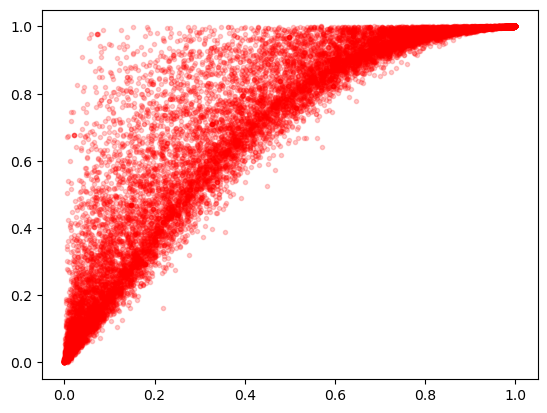

In [122]:
plt.plot(x, y, '.', color="red", alpha=0.2)

(array([2.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 4.000e+00, 4.000e+00, 1.000e+01, 1.000e+00, 7.000e+00,
        6.000e+00, 1.000e+01, 3.000e+00, 1.300e+01, 1.500e+01, 1.800e+01,
        1.600e+01, 2.200e+01, 2.300e+01, 1.600e+01, 2.200e+01, 3.100e+01,
        1.900e+01, 2.900e+01, 1.700e+01, 3.600e+01, 2.700e+01, 4.000e+01,
        3.300e+01, 3.700e+01, 4.500e+01, 5.400e+01, 4.500e+01, 5.200e+01,
        5.900e+01, 6.200e+01, 6.700e+01, 7.800e+01, 7.300e+01, 8.900e+01,
        8.400e+01, 9.100e+01, 1.210e+02, 9.300e+01, 1.360e+02, 1.170e+02,
        1.460e+02, 1.740e+02, 1.440e+02, 1.940e+02, 1.860e+02, 2.100e+02,
        2.160e+02, 2.520e+02, 3.150e+02, 3.450e+02, 3.990e+02, 4.550e+02,
        4.580e+02, 4.560e+02, 4.350e+02, 4.640e+02, 4.590e+02, 4.560e+02,
        4.180e+02, 4.650e+02, 4.240e+02, 4.410e+02, 4.120e+02, 4.240e+02,
        5.280e+02, 4.670e+02, 4.660e+0

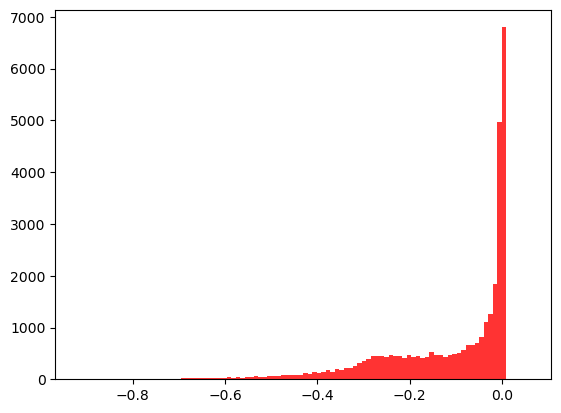

In [137]:
plt.hist([xx -yy for xx, yy in zip(x, y)],bins=100,color="red",alpha=0.8)